In [1]:
# Developer's setting
%load_ext autoreload
%autoreload 2

In [2]:
import gftt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors, cm
from matplotlib.colors import ListedColormap
import rasterio
from rasterio.plot import show
import numpy as np
import pandas as pd
import geopandas as gpd

In [3]:
df = pd.read_csv('../results_2022.csv', dtype=str)
df

,Date,Chip (px),Resolution (px),Prefilter,Subpixel,Software,Vx,Vy,OIE-x,OIE-y,OI-peak-x,OI-peak-y
0,Sen2-20180304-20180314,48,12,Gau,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,0.5234375,0.546875,-0.0703125,0.1953125
1,Sen2-20180304-20180314,48,12,NAOF,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,0.421875,0.4296875,-0.0625,0.1640625
2,Sen2-20180304-20180314,48,12,None,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,0.82421875,0.92578125,-0.0416666679084301,0.1354166716337204
3,Sen2-20180304-20180314,48,1,Gau,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,0.59375,0.578125,-0.0625,0.1875
4,Sen2-20180304-20180314,48,1,NAOF,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,0.40625,0.46875,-0.0625,0.15625
...,...,...,...,...,...,...,...,...,...,...,...,...
167,Sen2-20180508-20180627,64,8,Gau,pyrUP,autoRIFT,/home/jovyan/Projects/PX_comparison/PX/autoRIF...,/home/jovyan/Projects/PX_comparison/PX/autoRIF...,0.34062498807907104,0.5375000238418579,0.05000000074505806,-0.05000000074505806
168,Sen2-20180508-20180627,32,4,NAOF,pyrUP,autoRIFT,/home/jovyan/Projects/PX_comparison/PX/autoRIF...,/home/jovyan/Projects/PX_comparison/PX/autoRIF...,0.25,0.33125001192092896,0.03750000149011612,-0.012500000186264515
169,Sen2-20180508-20180627,32,8,NAOF,pyrUP,autoRIFT,/home/jovyan/Projects/PX_comparison/PX/autoRIF...,/home/jovyan/Projects/PX_comparison/PX/autoRIF...,0.16249999403953552,0.24687500298023224,0.03750000149011612,-0.02500000037252903
170,Sen2-20180508-20180627,64,4,NAOF,pyrUP,autoRIFT,/home/jovyan/Projects/PX_comparison/PX/autoRIF...,/home/jovyan/Projects/PX_comparison/PX/autoRIF...,0.17499999701976776,0.2562499940395355,0.03750000149011612,-0.012500000186264515


In [4]:
# on-ice area
in_shp = '/home/jovyan/Projects/PX_comparison/Bedrock_shp/glacier_V1_Kaskawulsh_s_inwardBuffer600m.shp'
on_ice = gpd.read_file(in_shp)

In [5]:
def get_reg_slope(n, edges):
    x = (edges[1:] + edges[:-1]) / 2
    n_idx = n >= 10
    x = x[n_idx]
    n = n[n_idx]
    n = np.log10(n)
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, n, rcond=None)[0]
    return np.abs(m)

In [6]:
def plot_oie_batch(demo, df):

    fig, ax   = plt.subplots(8, 6, figsize=(20, 28))
    fig2, ax2 = plt.subplots(8, 6, figsize=(20, 28))

    n = 0

    for idx, row in demo.iterrows():
        label = '-'.join((row.Software, row['Chip (px)'], row['Resolution (px)'], row.Prefilter)) + '\n' + row.Subpixel
        ax_sel  = ax[n // 6, n % 6]
        ax_sel2 = ax2[n // 6, n % 6]
        
        e1s, e2s, z, thres_idx, exx, eyy, exy, duxdy, duydx, theta, e1, e2, exy_rot, exy_rot_masked, exx_rot, eyy_rot = gftt.sobel_strain_test(vxfile=row.Vx, vyfile=row.Vy, on_ice_area=in_shp, plot=False, return_sobelimage=True)

        e_min = np.minimum(np.abs(e1), np.abs(e2))
        e_min = e_min.flatten()
        real_e_max = np.maximum(np.abs(exx_rot), np.abs(eyy_rot))
        real_e_max = real_e_max.flatten()

        sn, edges, _ = ax_sel.hist(e_min, bins=np.arange(0, 35, 0.25))
        m_emin = get_reg_slope(sn, edges)
        # m_emins.append(m_emin)
        sn, edges, _ = ax_sel2.hist(real_e_max, bins=np.arange(0, 35, 0.25))
        m_emax = get_reg_slope(sn, edges)
        # m_emaxs.append(m_emax)
        
        df.loc[idx, 'slope_max-normal-E'] = m_emax
        df.loc[idx, 'slope_min-shear-E'] = m_emin
        df.loc[idx, 'E_ratio'] = m_emax / m_emin
    
        ax_sel.set_yscale('log', nonpositive='clip')
        ax_sel.set_xlabel(r'$min(|\epsilon_1|, |\epsilon_2|)$')
        ax_sel.set_xlim([0, 35])
        ax_sel.set_ylim([0.5, 2e7])
        ax_sel.set_ylabel('N')
        label1 = label + '\n m = {:6.3f}'.format(-m_emin)
        ax_sel.set_title(label1)
        ax_sel2.set_yscale('log', nonpositive='clip')
        ax_sel2.set_xlabel(r'$max(|\epsilon_{xx}|, |\epsilon_{yy}|)$ (along-flow)')
        ax_sel2.set_xlim([0, 35])
        ax_sel2.set_ylim([0.5, 2e7])
        ax_sel2.set_ylabel('N')
        label2 = label + '\n m = {:6.3f}'.format(-m_emax)
        ax_sel2.set_title(label2)
        # all_labels.append(label)
        n += 1
        
    for i in range(n, 48):
        ax_sel = ax[i // 6, i % 6]
        fig.delaxes(ax_sel)
        ax_sel = ax2[i // 6, i % 6]
        fig2.delaxes(ax_sel)
        
    fig.tight_layout()
    fig2.tight_layout()
    fig.patch.set_facecolor('xkcd:white')
    fig2.patch.set_facecolor('xkcd:white')
    return fig, fig2, df


/home/jovyan/Projects/Github/glacier-ft-test/gftt/metrics.py:310: RuntimeWarning: divide by zero encountered in true_divide
  theta = 0.5 * np.arctan(2 * exy / (exx - eyy))
/home/jovyan/Projects/Github/glacier-ft-test/gftt/metrics.py:310: RuntimeWarning: invalid value encountered in true_divide
  theta = 0.5 * np.arctan(2 * exy / (exx - eyy))


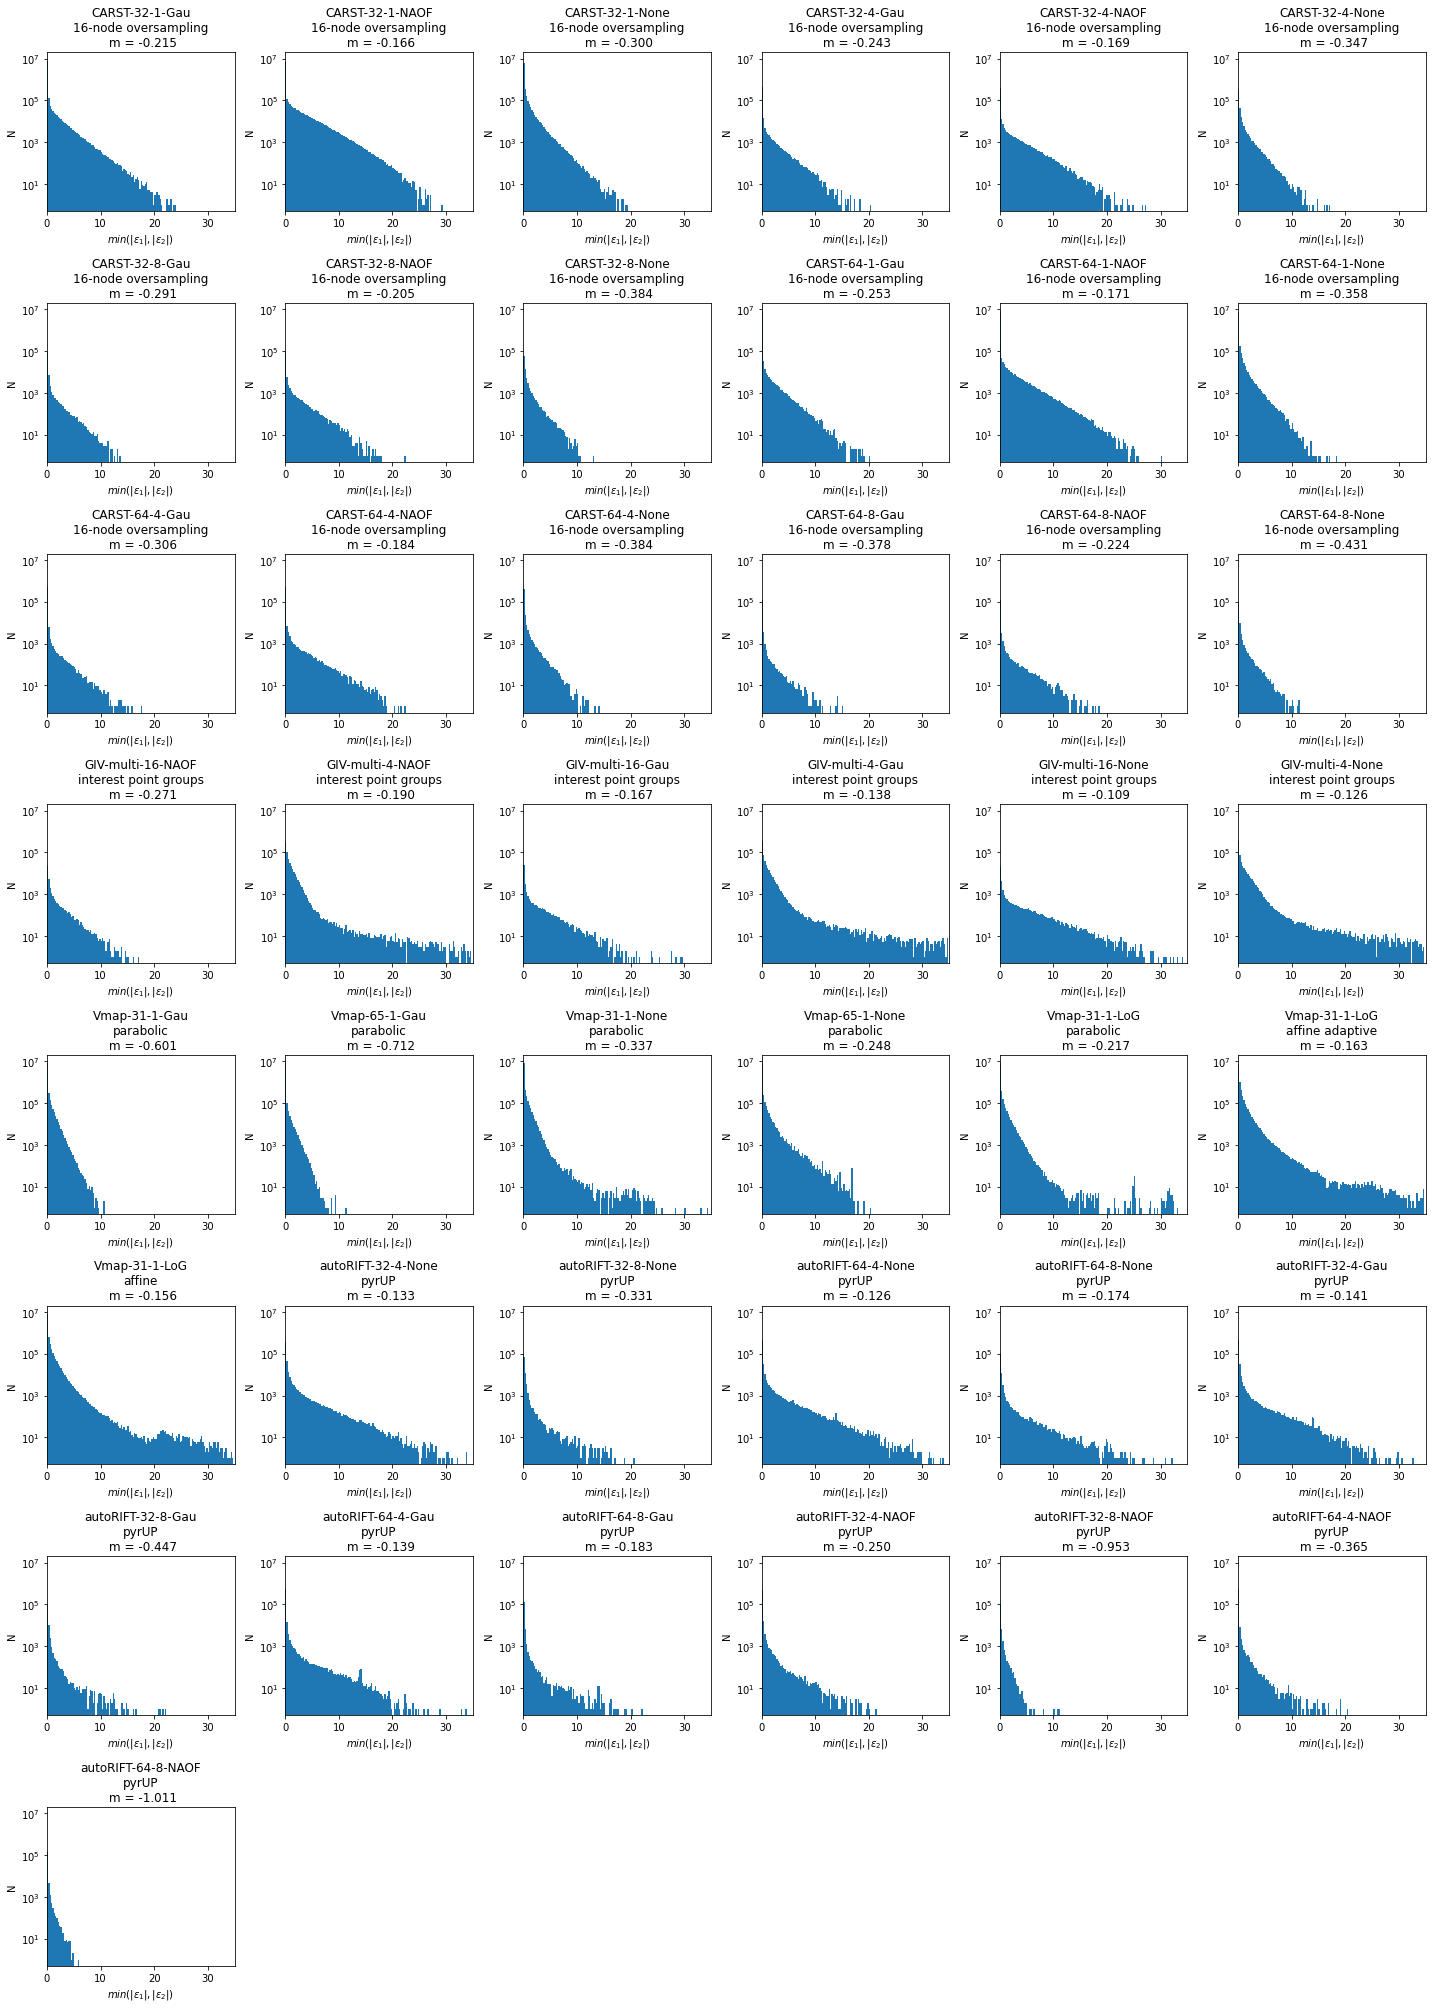

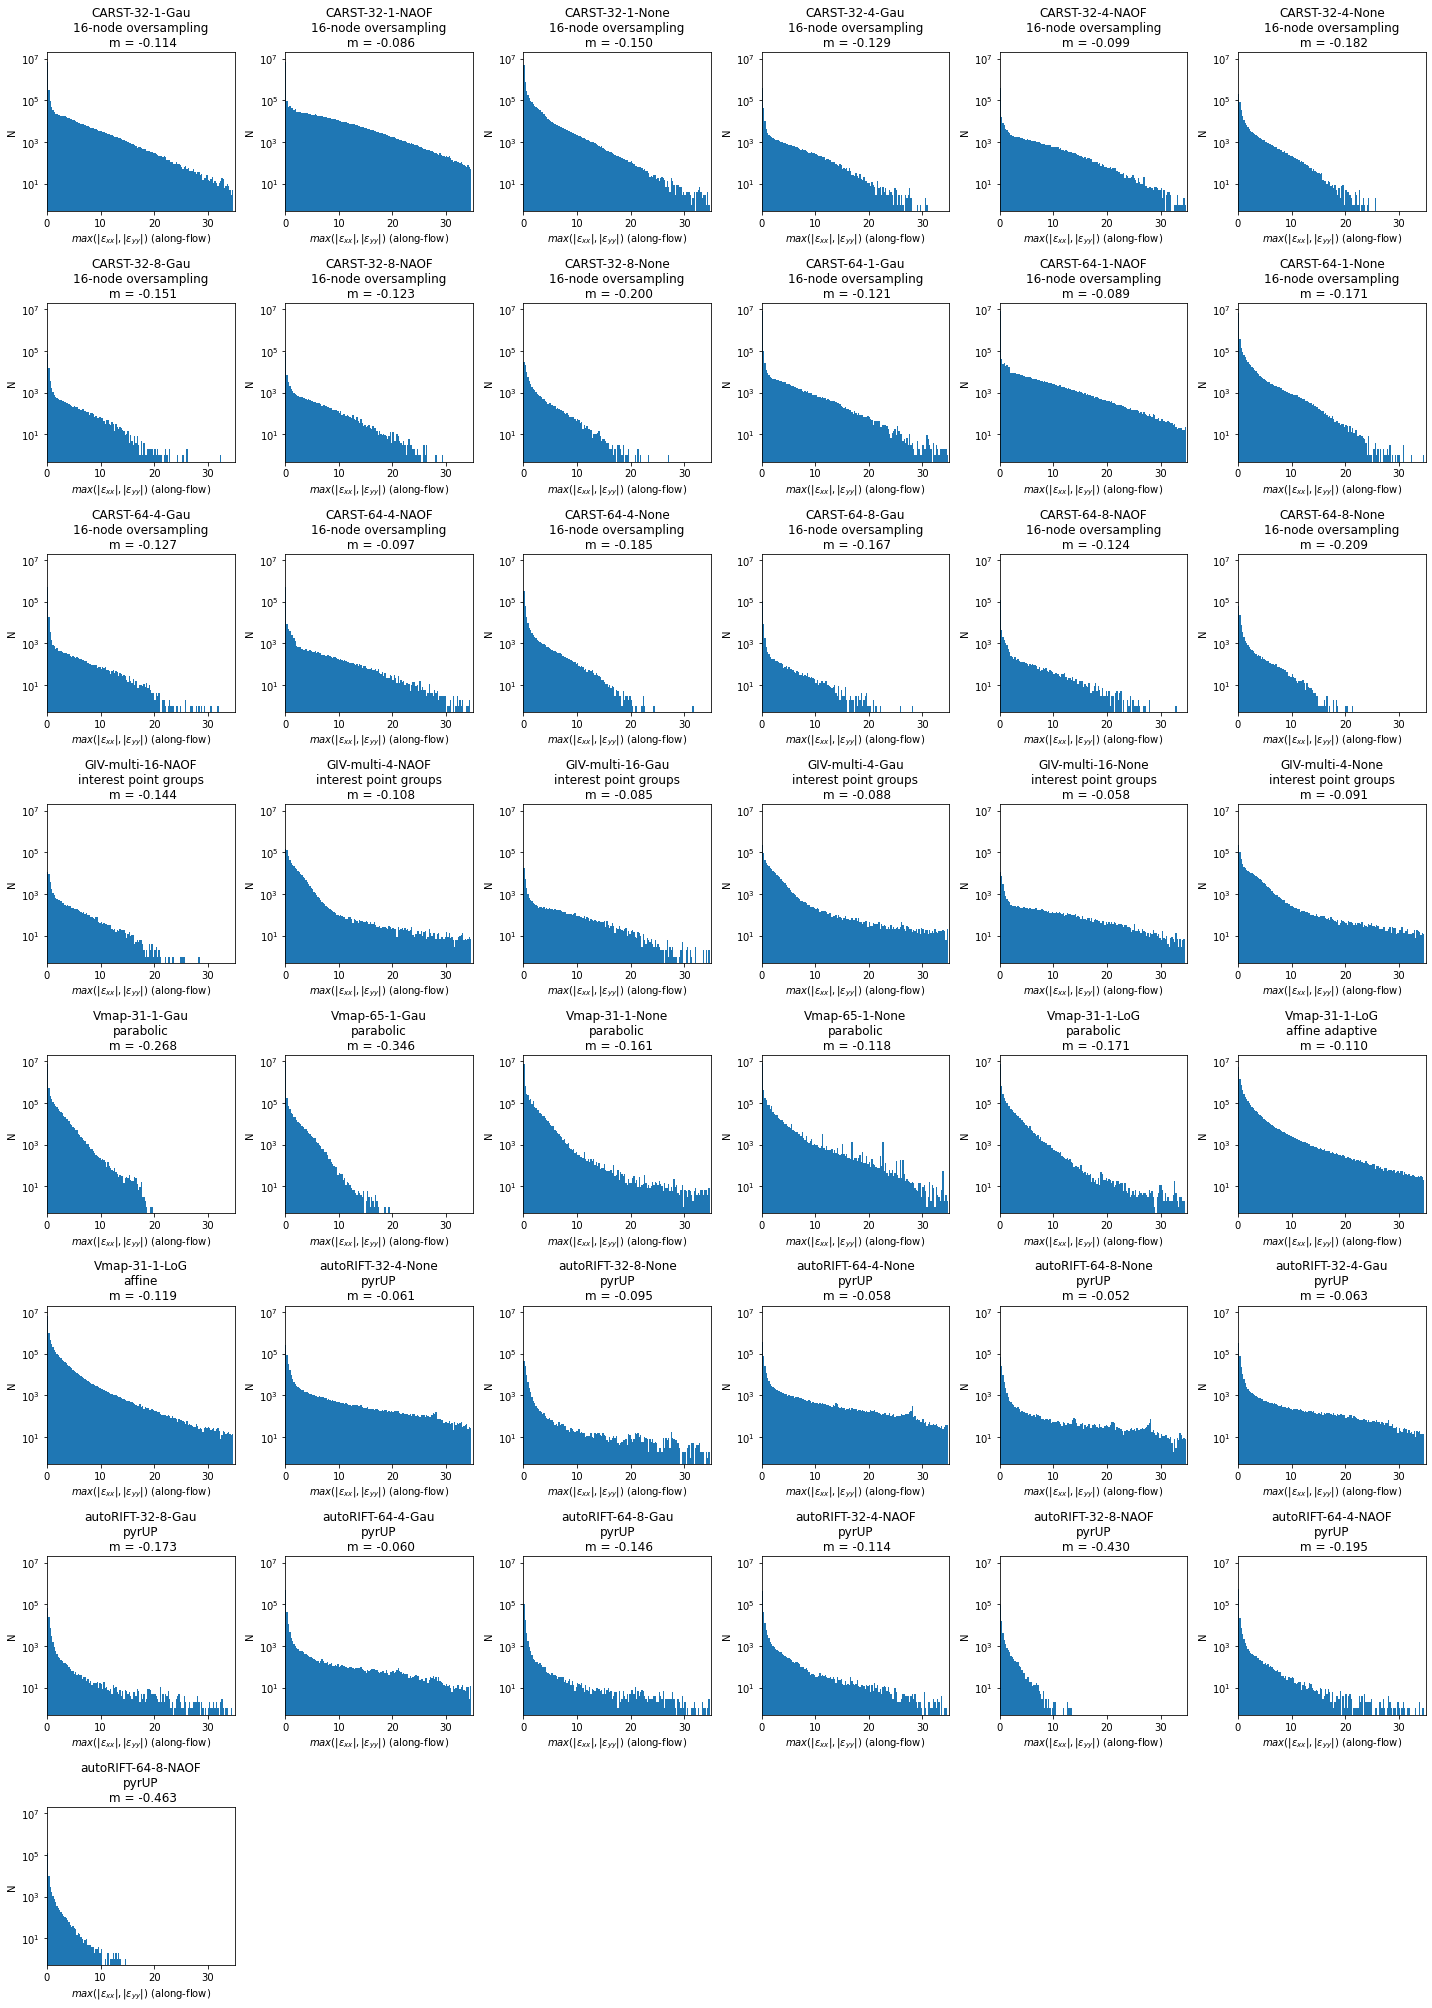

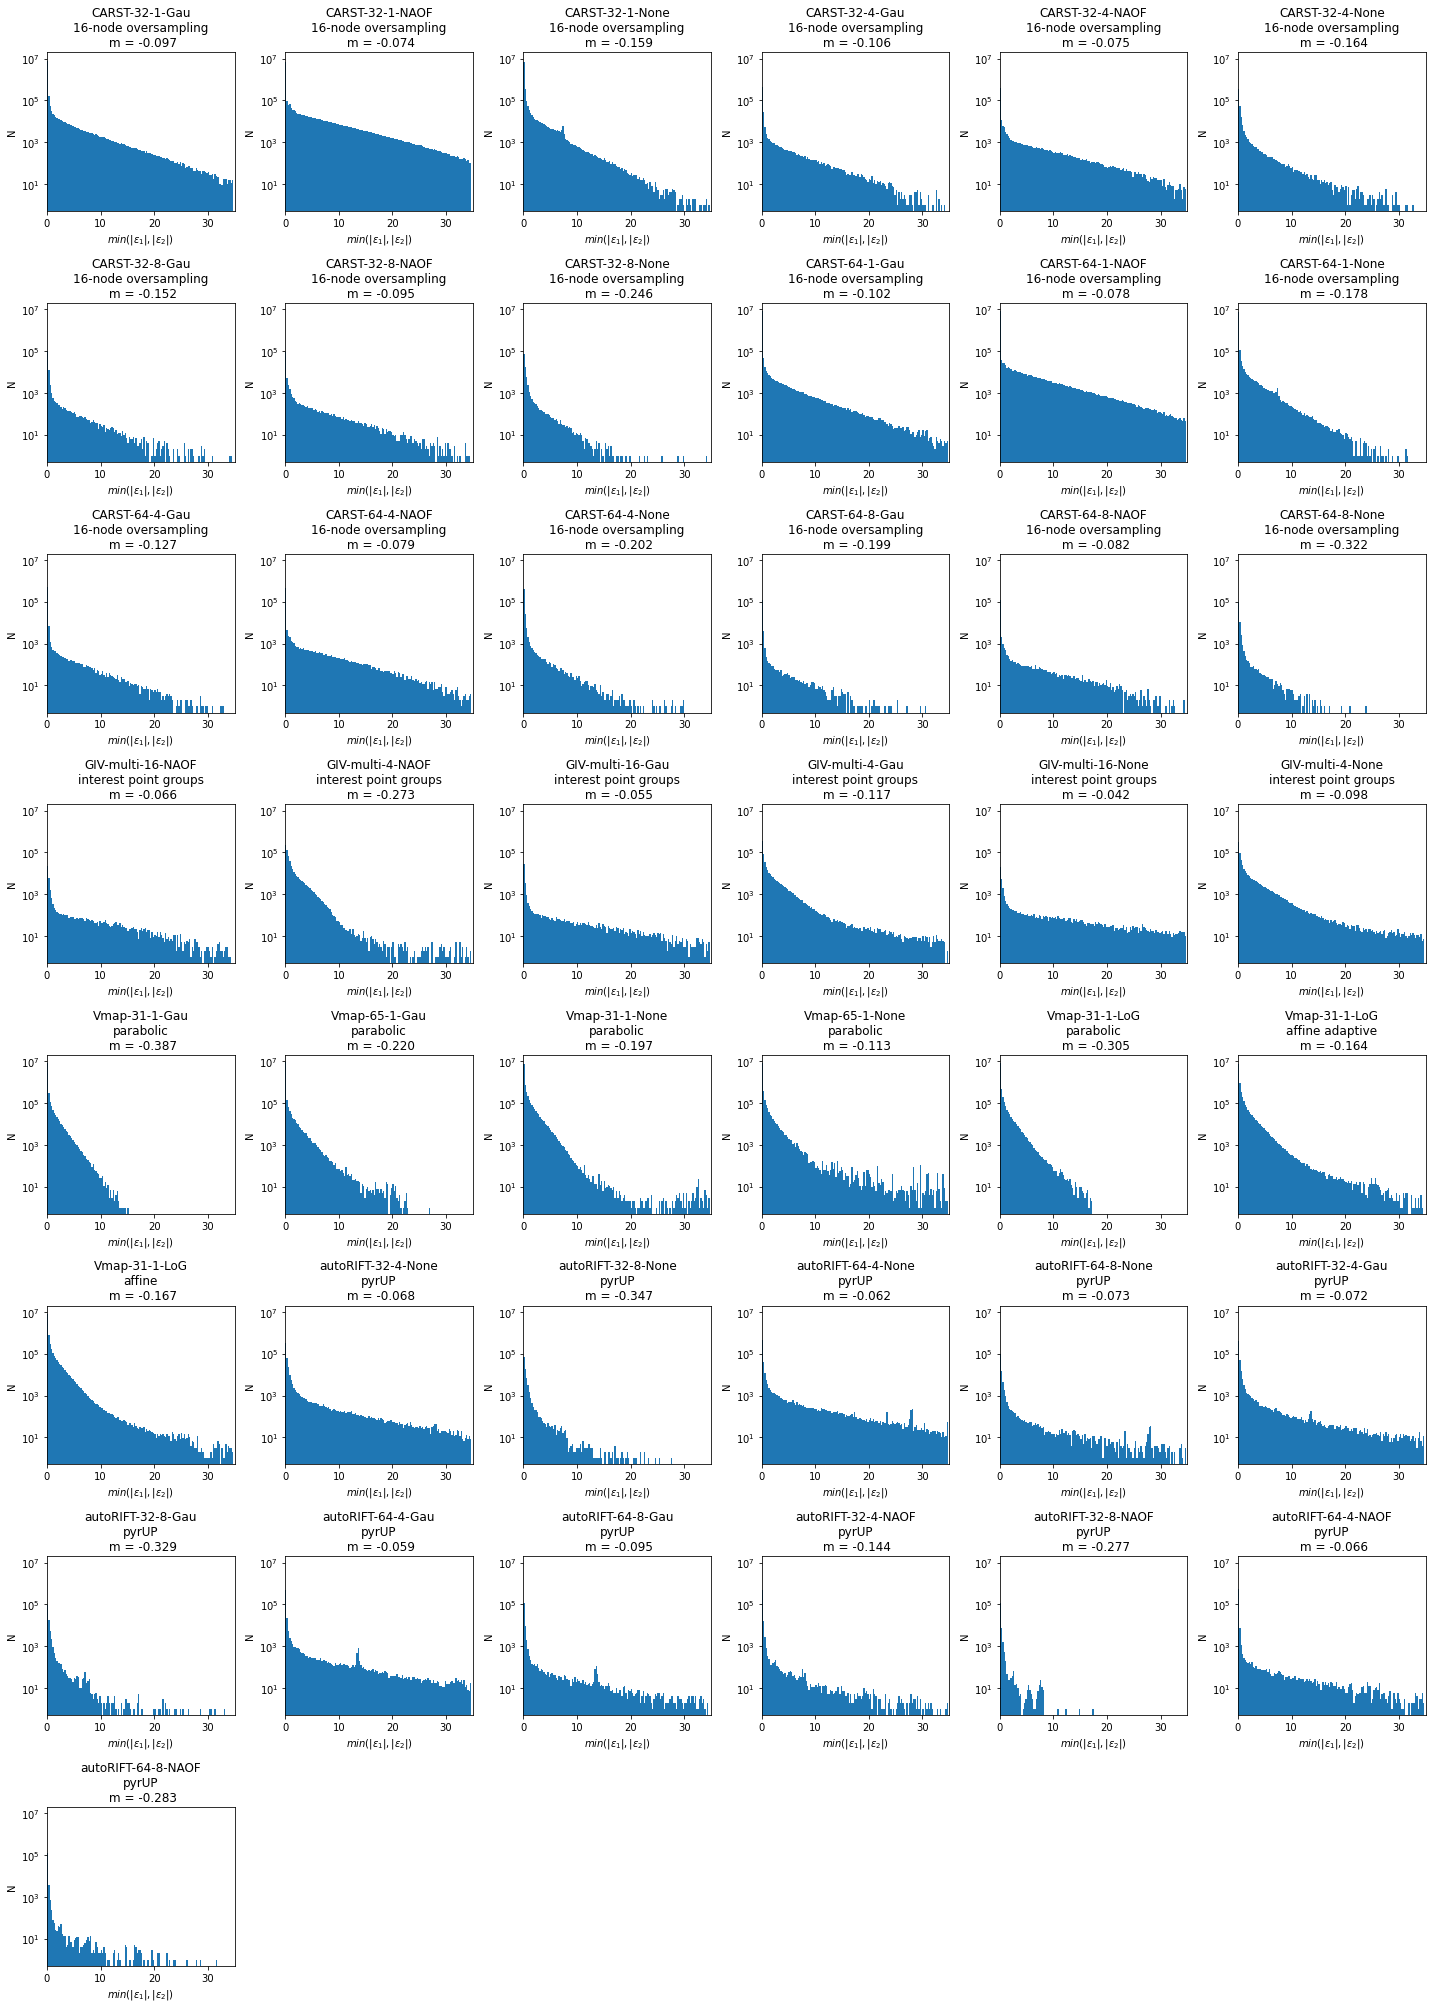

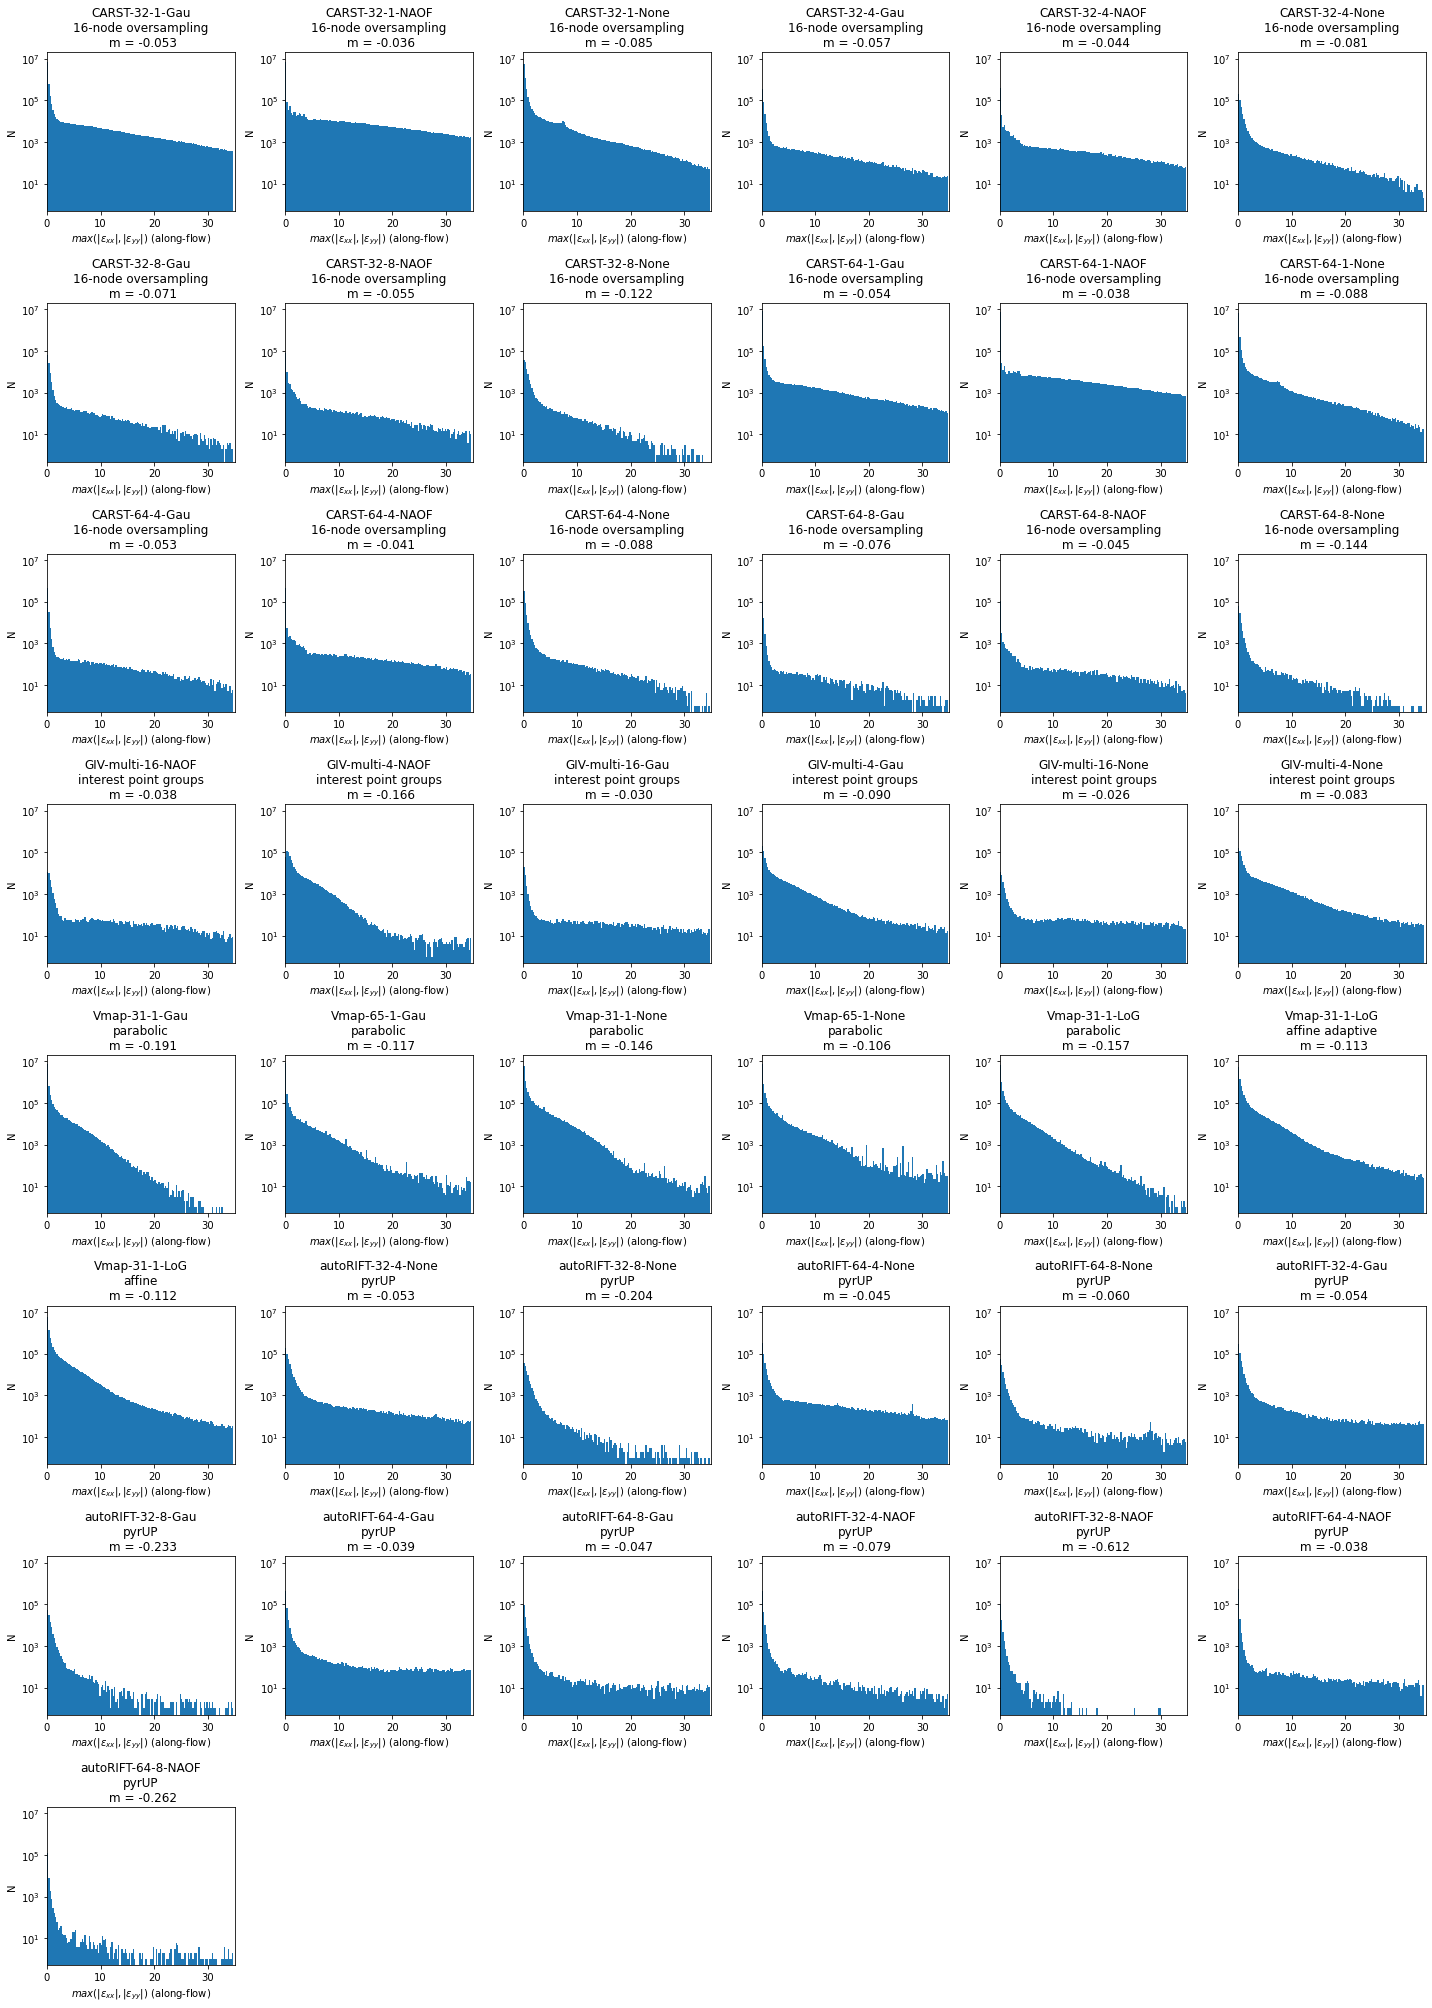

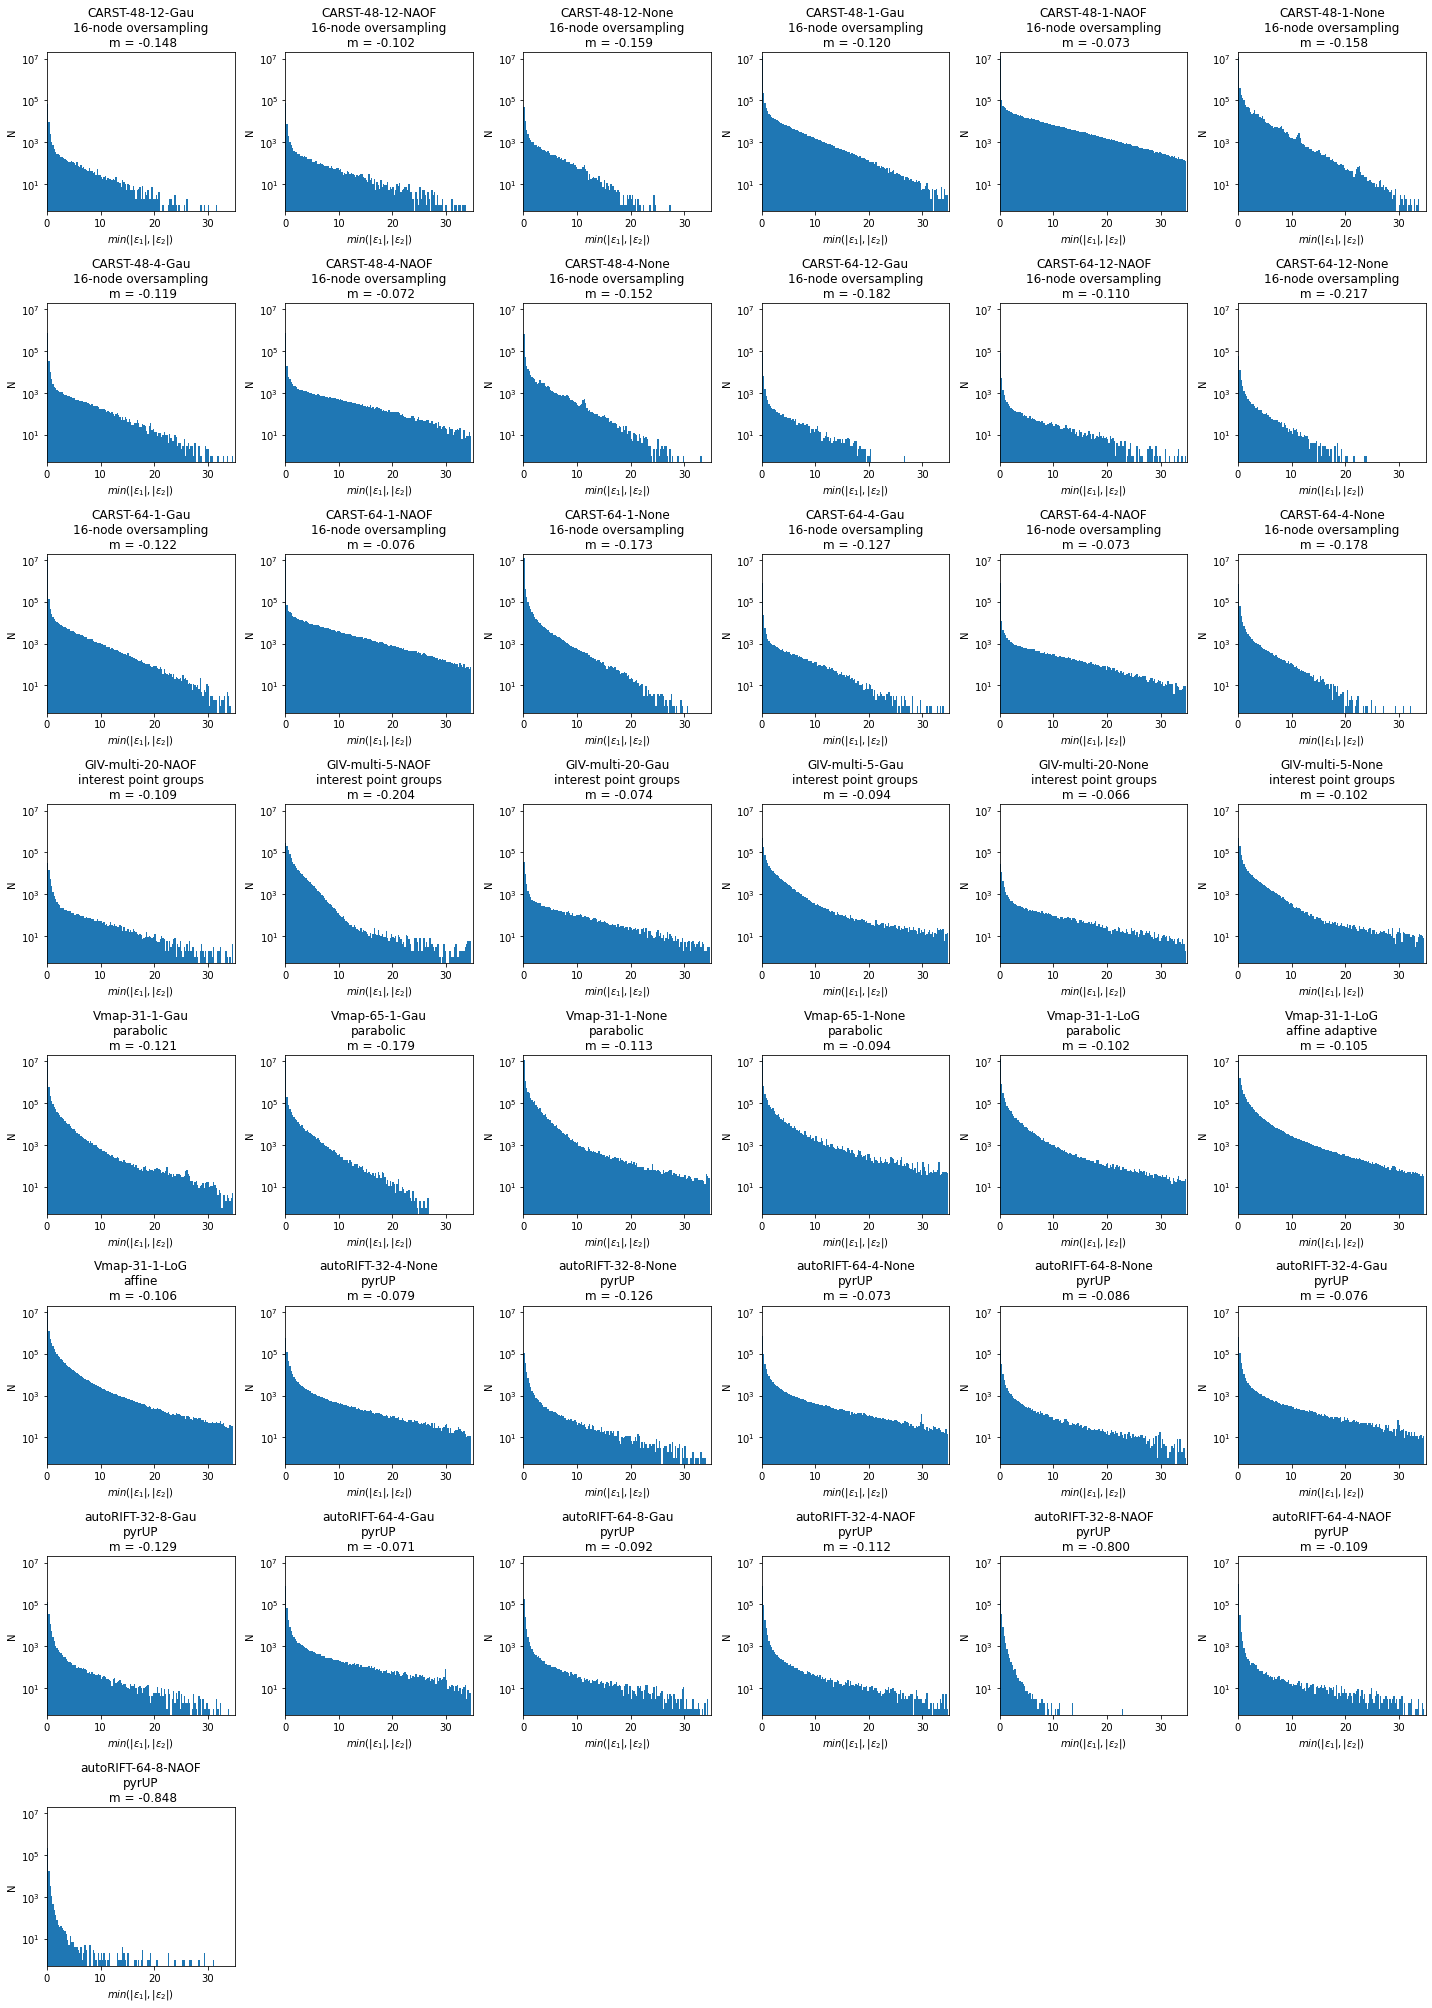

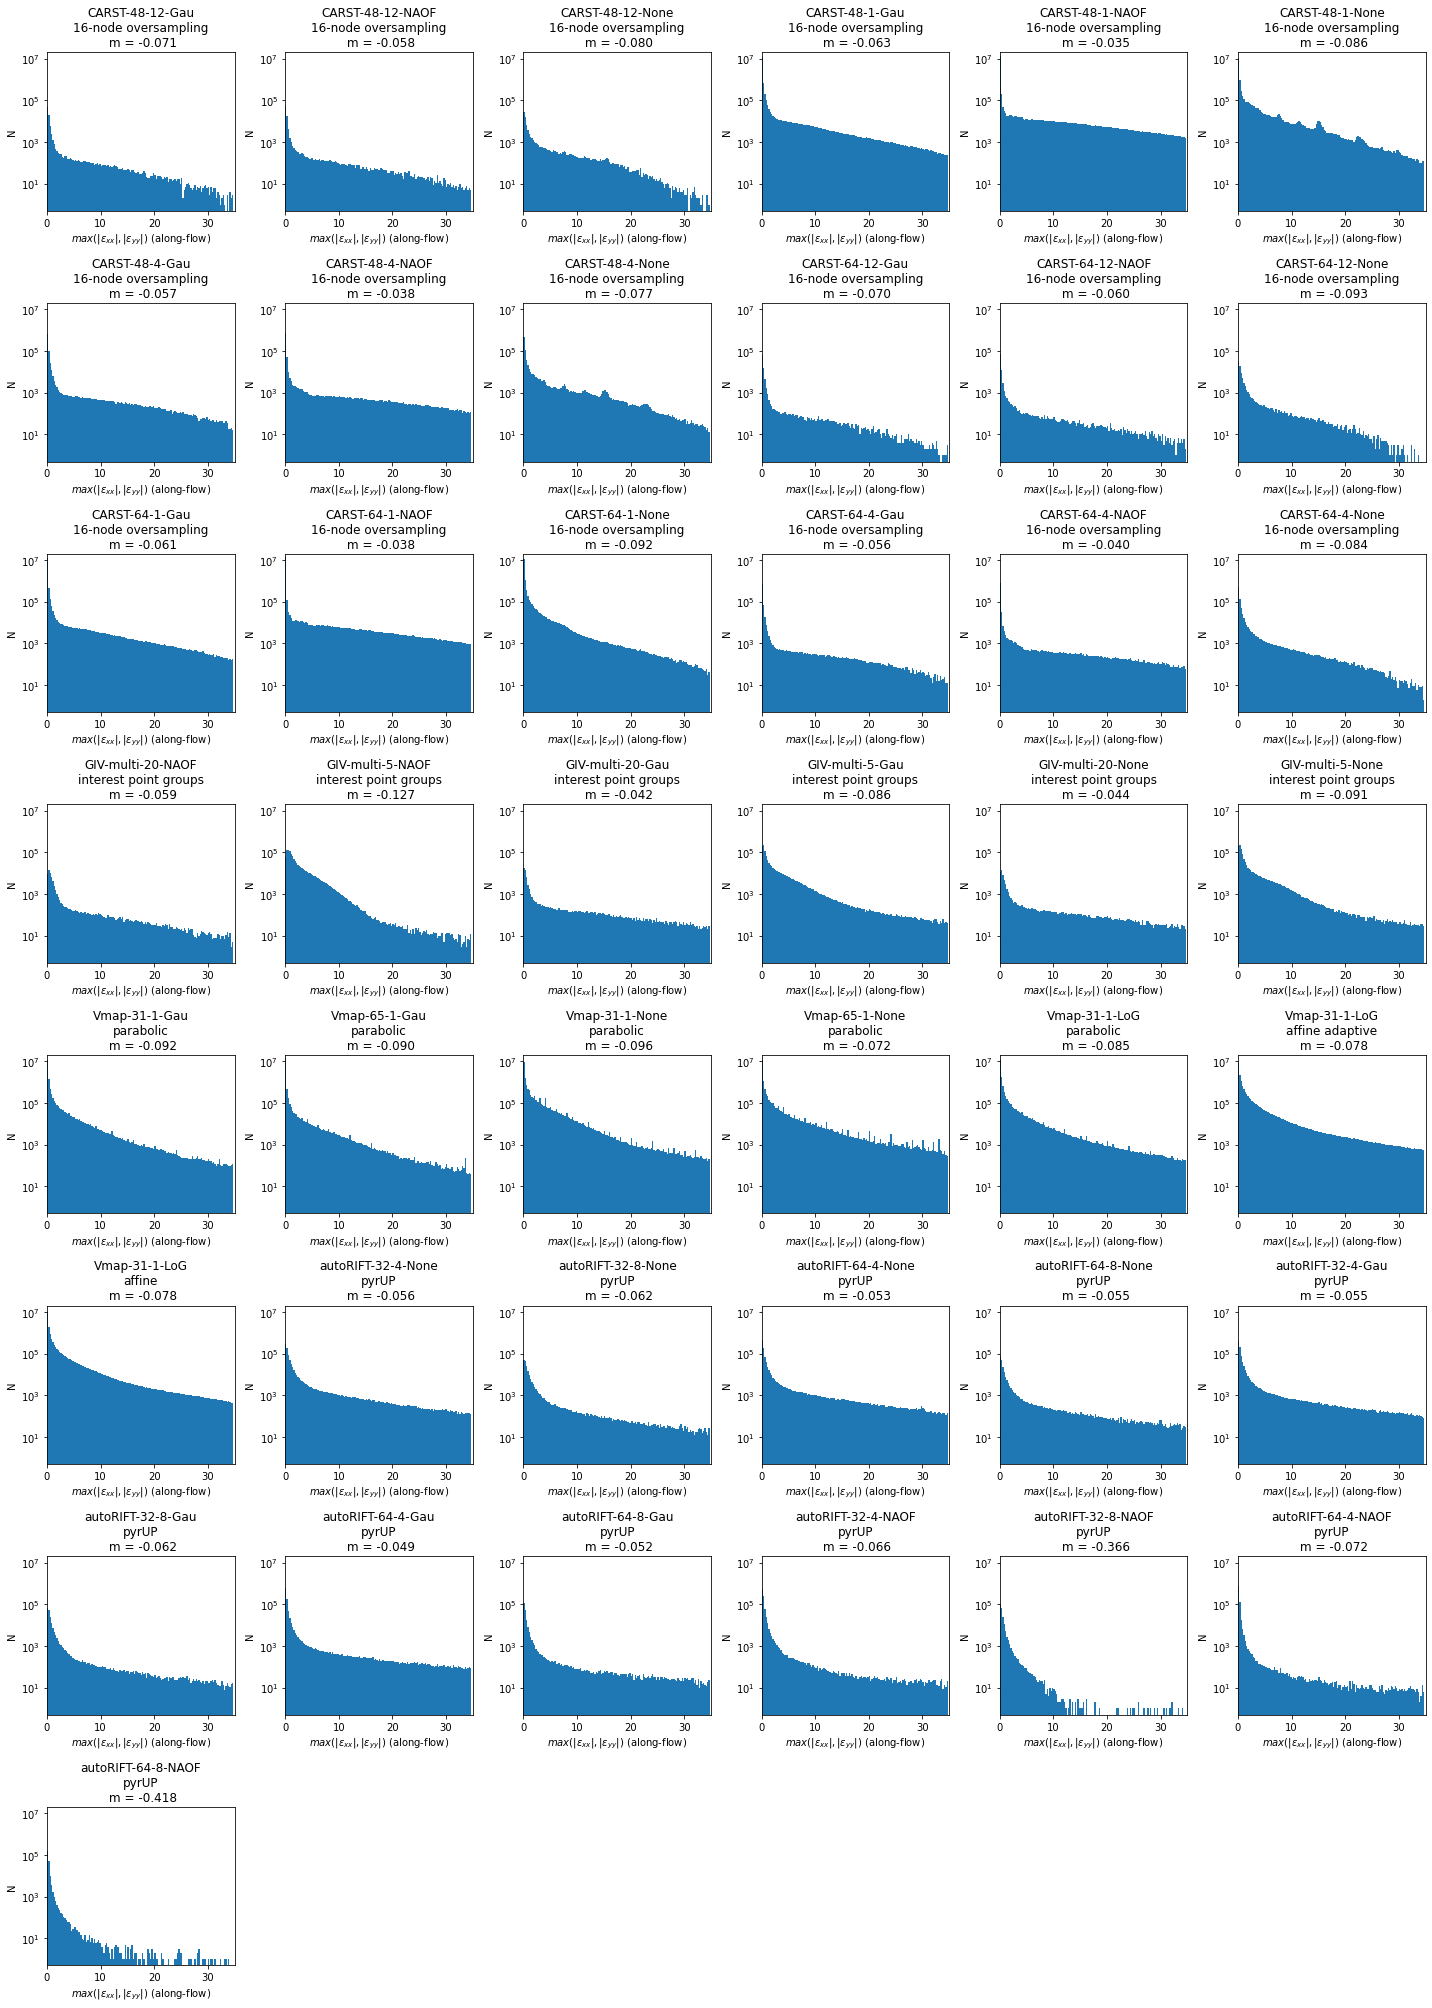

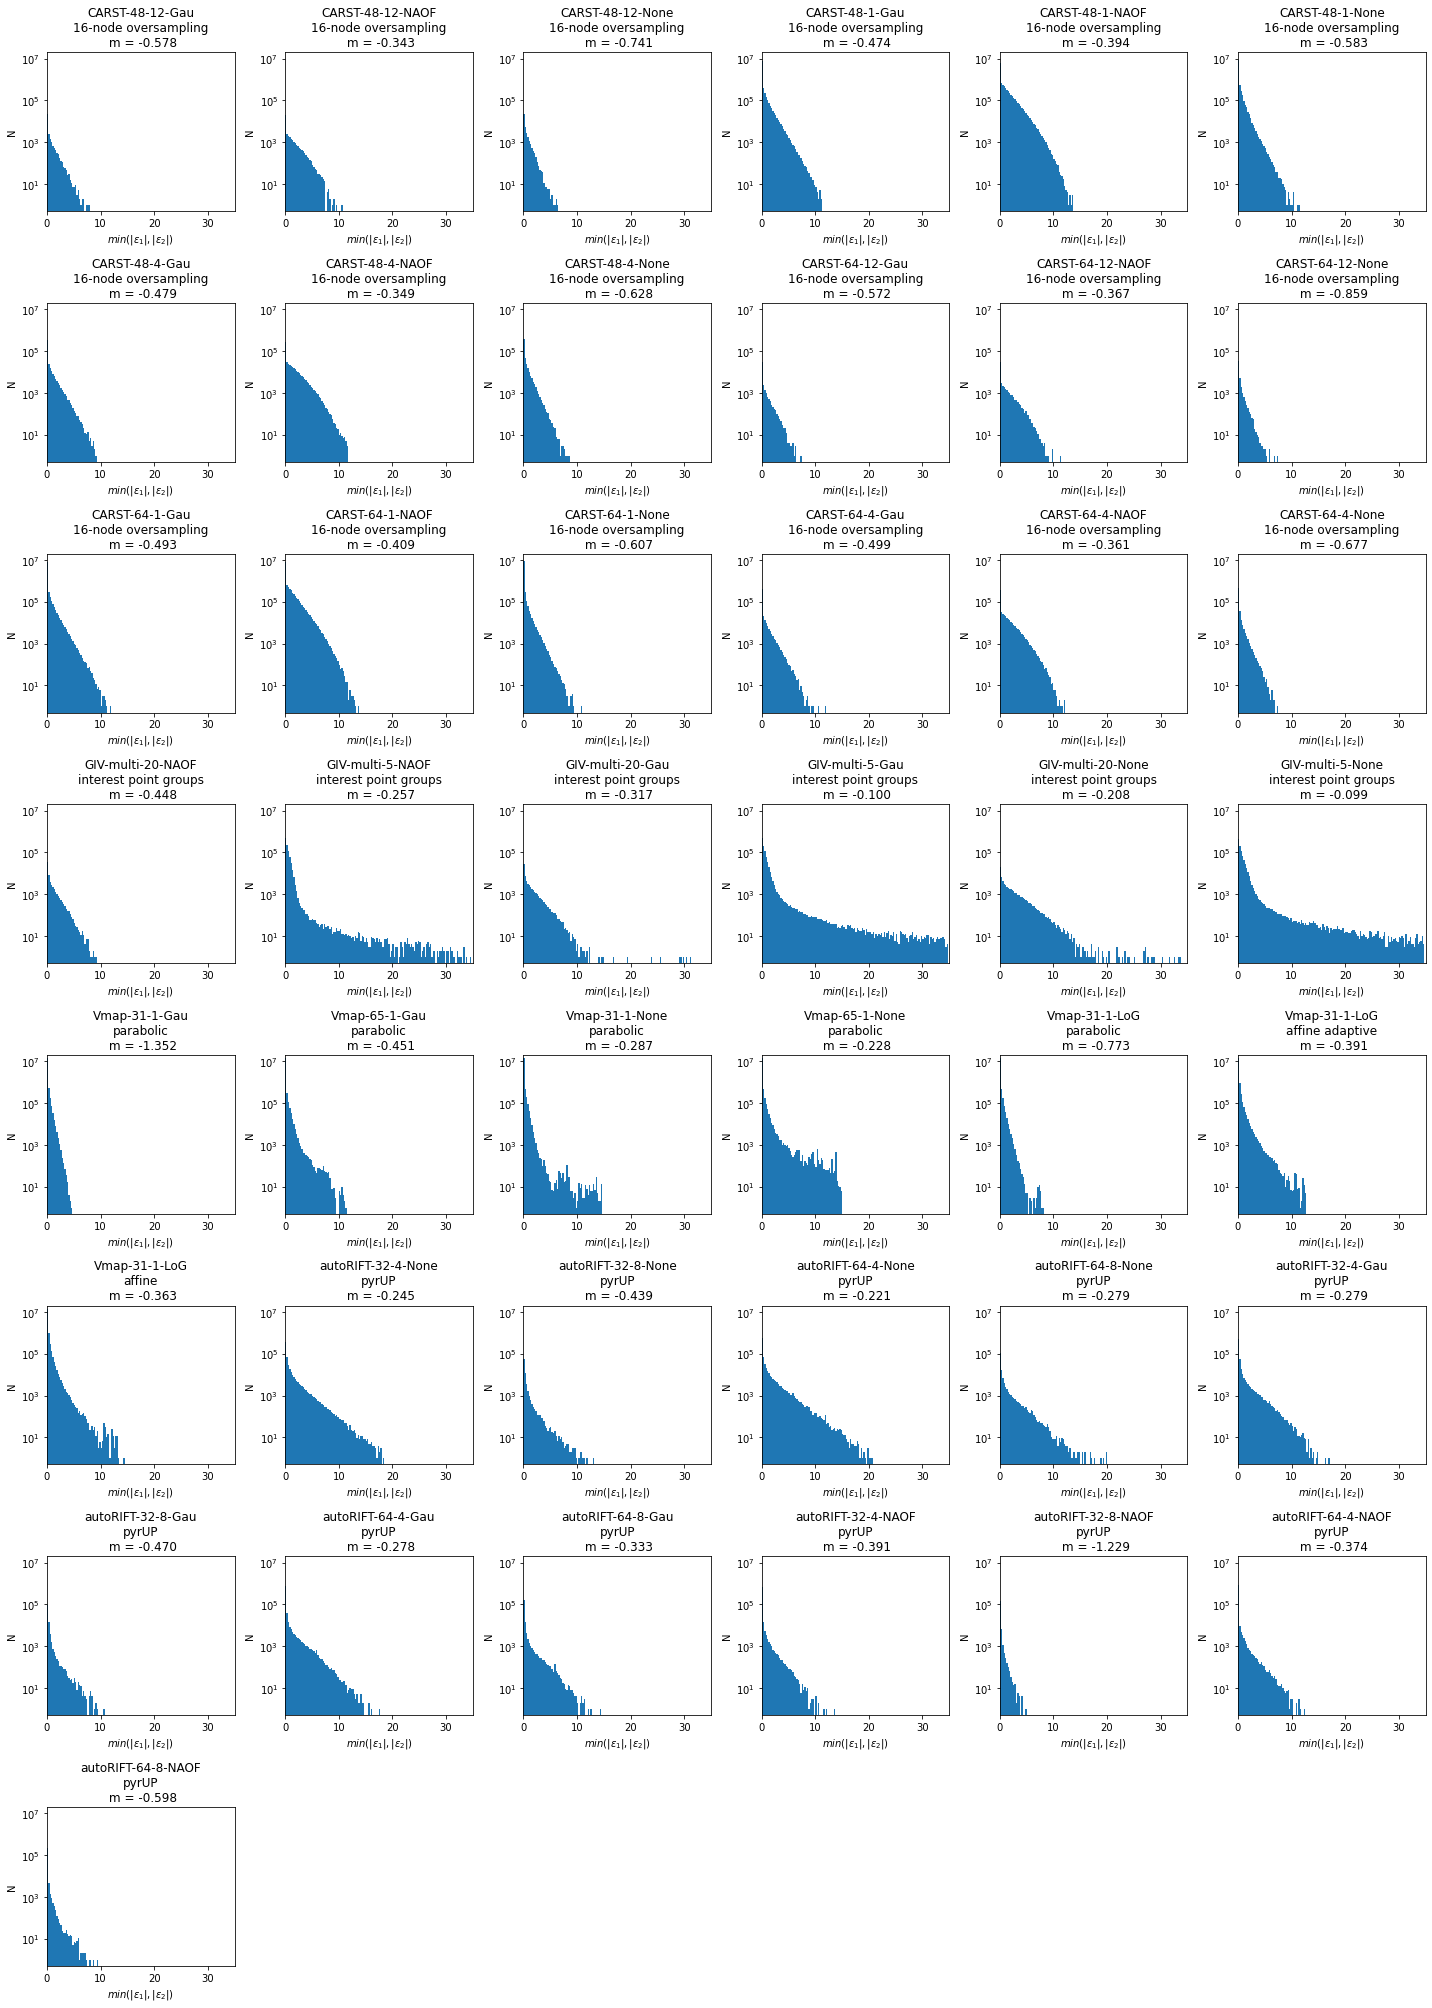

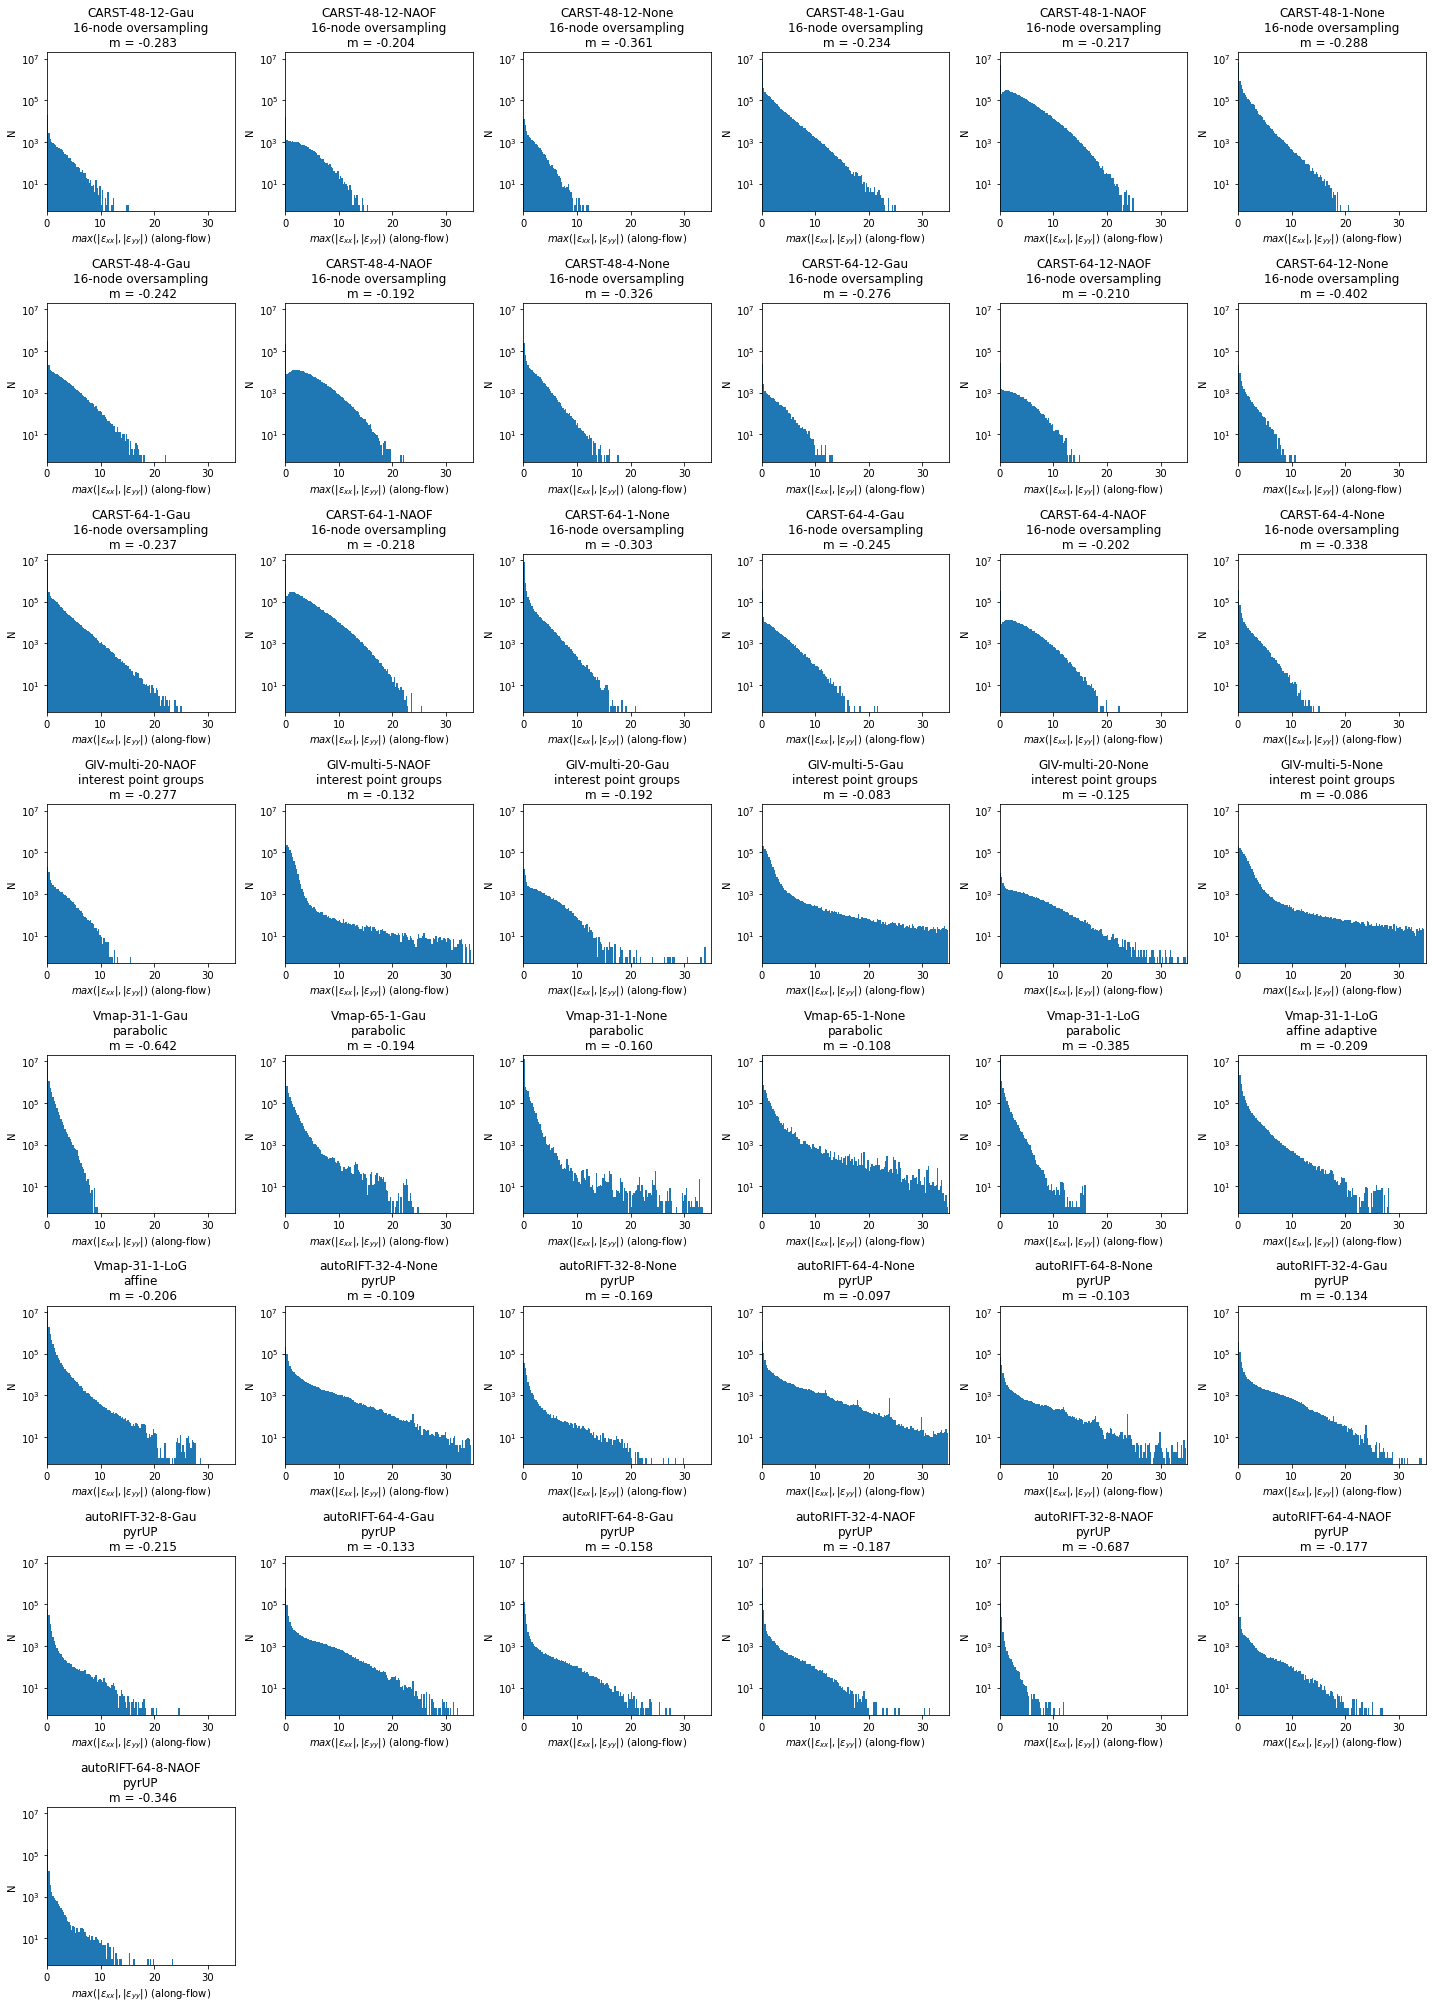

In [7]:
for datestr in ['LS8-20180304-20180405', 'LS8-20180802-20180818', 'Sen2-20180304-20180314', 'Sen2-20180508-20180627']:
    demo = df.loc[df['Date'] == datestr]
    fig, fig2, df = plot_oie_batch(demo, df)
    fig.savefig('figs/' + datestr + '-slope_min-shear-E.png')
    fig2.savefig('figs/' + datestr + '-slope_max-normal-E.png')

In [8]:
df.to_csv('../results_2022.csv', index=False)
# df

In [9]:
df

,Date,Chip (px),Resolution (px),Prefilter,Subpixel,Software,Vx,Vy,OIE-x,OIE-y,OI-peak-x,OI-peak-y,slope_max-normal-E,slope_min-shear-E,E_ratio
0,Sen2-20180304-20180314,48,12,Gau,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,0.5234375,0.546875,-0.0703125,0.1953125,0.071212,0.147663,0.482265
1,Sen2-20180304-20180314,48,12,NAOF,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,0.421875,0.4296875,-0.0625,0.1640625,0.057826,0.101876,0.567611
2,Sen2-20180304-20180314,48,12,None,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,0.82421875,0.92578125,-0.0416666679084301,0.1354166716337204,0.080115,0.158693,0.504841
3,Sen2-20180304-20180314,48,1,Gau,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,0.59375,0.578125,-0.0625,0.1875,0.062518,0.120220,0.520035
4,Sen2-20180304-20180314,48,1,NAOF,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,0.40625,0.46875,-0.0625,0.15625,0.035411,0.073263,0.483342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,Sen2-20180508-20180627,64,8,Gau,pyrUP,autoRIFT,/home/jovyan/Projects/PX_comparison/PX/autoRIF...,/home/jovyan/Projects/PX_comparison/PX/autoRIF...,0.34062498807907104,0.5375000238418579,0.05000000074505806,-0.05000000074505806,0.157609,0.332714,0.473707
168,Sen2-20180508-20180627,32,4,NAOF,pyrUP,autoRIFT,/home/jovyan/Projects/PX_comparison/PX/autoRIF...,/home/jovyan/Projects/PX_comparison/PX/autoRIF...,0.25,0.33125001192092896,0.03750000149011612,-0.012500000186264515,0.187083,0.390503,0.479083
169,Sen2-20180508-20180627,32,8,NAOF,pyrUP,autoRIFT,/home/jovyan/Projects/PX_comparison/PX/autoRIF...,/home/jovyan/Projects/PX_comparison/PX/autoRIF...,0.16249999403953552,0.24687500298023224,0.03750000149011612,-0.02500000037252903,0.687276,1.228652,0.559374
170,Sen2-20180508-20180627,64,4,NAOF,pyrUP,autoRIFT,/home/jovyan/Projects/PX_comparison/PX/autoRIF...,/home/jovyan/Projects/PX_comparison/PX/autoRIF...,0.17499999701976776,0.2562499940395355,0.03750000149011612,-0.012500000186264515,0.176882,0.374439,0.472391
